In [30]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
# Unzip the dataset
import zipfile
import os
zip_file_path = "/content/drive/MyDrive/Insect_dataset_ancy.zip"
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall("/content/dataset")

In [32]:
# Set the path to the extracted dataset
dataset_path = "/content/dataset/farm_insects"  # Update with your dataset folder

# Initialize data and labels
data = []
labels = []


In [33]:
import cv2
# Loop over the image paths in the dataset
for subdir, dirs, files in os.walk(dataset_path):
    for file in files:
        # Load the image, preprocess it, and store it in the data list
        image_path = os.path.join(subdir, file)
        image = cv2.imread(image_path)
        if image is not None:  # Check if the image was correctly read
            image = cv2.resize(image, (128, 128))  # Resizing to 128x128
            data.append(image)

            # Extract the class label from the directory name and update the labels list
            label = subdir.split(os.path.sep)[-1]
            labels.append(label)
        else:
            print(f"Warning: Unable to read image {image_path}")


In [34]:
# Loop over the image paths in the dataset
for subdir, dirs, files in os.walk(dataset_path):
    for file in files:
        # Ignore .gif files
        if file.lower().endswith(".gif"):
            print(f"Ignored file: {file}")
            continue

        # Load the image, preprocess it, and store it in the data list
        image_path = os.path.join(subdir, file)
        image = cv2.imread(image_path)
        if image is not None:  # Check if the image was correctly read
            image = cv2.resize(image, (128, 128))  # Resizing to 128x128
            data.append(image)

            # Extract the class label from the directory name and update the labels list
            label = subdir.split(os.path.sep)[-1]
            labels.append(label)
        else:
            print(f"Warning: Unable to read image {image_path}")

Ignored file: Image_115.gif
Ignored file: Image_116.gif
Ignored file: Image_49.gif
Ignored file: Image_23.gif
Ignored file: Image_62.gif
Ignored file: Image_68.gif
Ignored file: Image_40.gif
Ignored file: Image_81.gif
Ignored file: Image_4.gif
Ignored file: Image_64.gif
Ignored file: Image_27.gif
Ignored file: Image_35.gif


In [37]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import numpy as np

# Convert data and labels to numpy arrays
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

print(f"Data shape: {data.shape}")
print(f"Labels shape: {labels.shape}")

# Binarize the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

# Split the data into training and testing sets
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2, random_state=42)

print(f"Train data shape: {trainX.shape}")
print(f"Test data shape: {testX.shape}")
print(f"Train labels shape: {trainY.shape}")
print(f"Test labels shape: {testY.shape}")

Data shape: (3158, 128, 128, 3)
Labels shape: (3158,)
Train data shape: (2526, 128, 128, 3)
Test data shape: (632, 128, 128, 3)
Train labels shape: (2526, 15)
Test labels shape: (632, 15)


In [40]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import tensorflow as tf

# Data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Define the CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), padding="same", input_shape=(128, 128, 3)))
model.add(tf.keras.layers.Activation("relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(tf.keras.layers.Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(tf.keras.layers.Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(tf.keras.layers.Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(len(lb.classes_)))
model.add(tf.keras.layers.Activation("softmax"))

# Compile the model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Summary of the model
model.summary()

"""
# Train the model
EPOCHS = 10
BS = 32

H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    validation_data=(testX, testY),
    steps_per_epoch=len(trainX) // BS,
    epochs=EPOCHS,
    verbose=1
)
"""
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    validation_data=(testX, testY),
    steps_per_epoch=len(trainX) // BS,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    verbose=1
)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 42, 42, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 42, 42, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 42, 42, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 42, 42, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 21, 21, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 21, 21, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 21, 21, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 21, 21, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │       6,554,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 15)                  │           7,695 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 15)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,655,055 (25.39 MB)

 Trainable params: 6,655,055 (25.39 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 80s 980ms/step - accuracy: 0.0945 - loss: 2.7684 - val_accuracy: 0.1218 - val_loss: 2.6167
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.0938 - loss: 2.6297 - val_accuracy: 0.1187 - val_loss: 2.6184
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 76s 962ms/step - accuracy: 0.1371 - loss: 2.5837 - val_accuracy: 0.1883 - val_loss: 2.4693
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.1250 - loss: 2.3890 - val_accuracy: 0.1582 - val_loss: 2.4704
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 79s 958ms/step - accuracy: 0.1548 - loss: 2.5167 - val_accuracy: 0.1851 - val_loss: 2.4716
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 0.2812 - loss: 2.2706 - val_accuracy: 0.1804 - val_loss: 2.5152
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 75s 953ms/step - accuracy: 0.1970 - loss: 2.4414 - val_accuracy: 0.2152 - val_loss: 2.3735
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.0625 - loss: 2.8371 - val_accuracy: 

In [41]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout

# Load the pre-trained MobileNet model, excluding the top layer
base_model_1 = MobileNet(weights="imagenet", include_top=False, input_shape=(128, 128, 3))

# Add custom layers on top
x1 = base_model_1.output
x1 = Flatten()(x1)
x1 = Dense(512, activation="relu")(x1)
x1 = Dropout(0.5)(x1)
predictions = Dense(len(lb.classes_), activation="softmax")(x1)

# Define the model
model = Model(inputs=base_model_1.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model_1.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Summary of the model
model.summary()

# Train the model
EPOCHS = 10
BS = 32

H1 = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    validation_data=(testX, testY),
    steps_per_epoch=len(trainX) // BS,
    epochs=EPOCHS,
    verbose=1
)

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 64, 64, 32)          │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 64, 64, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 64, 64, 32)          │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 64, 64, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 64, 64, 64)          │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 64, 64, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 65, 65, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 32, 32, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 32, 32, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 32, 32, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 32, 32, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 32, 32, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 32, 32, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 32, 32, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 11,625,679 (44.35 MB)

 Trainable params: 8,396,815 (32.03 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


78/78 ━━━━━━━━━━━━━━━━━━━━ 71s 838ms/step - accuracy: 0.2182 - loss: 5.9037 - val_accuracy: 0.5475 - val_loss: 1.4846
Epoch 2/10
 1/78 ━━━━━━━━━━━━━━━━━━━━ 36s 472ms/step - accuracy: 0.5000 - loss: 2.0755

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 0.5000 - loss: 2.0755 - val_accuracy: 0.5427 - val_loss: 1.4788
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 61s 771ms/step - accuracy: 0.4546 - loss: 1.7926 - val_accuracy: 0.6044 - val_loss: 1.1910
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - accuracy: 0.5625 - loss: 1.2591 - val_accuracy: 0.6155 - val_loss: 1.1892
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 78s 819ms/step - accuracy: 0.4927 - loss: 1.5830 - val_accuracy: 0.6377 - val_loss: 1.0834
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 0.3750 - loss: 1.2807 - val_accuracy: 0.6329 - val_loss: 1.0925
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 63s 802ms/step - accuracy: 0.5481 - loss: 1.4346 - val_accuracy: 0.6677 - val_loss: 1.0218
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - accuracy: 0.5312 - loss: 1.5084 - val_accuracy: 0.6646 - val_loss: 1.0273
Epoch 9/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 65s 828ms/step - accuracy: 0.5525 - loss: 1.3997 - val_accuracy: 0.7247 

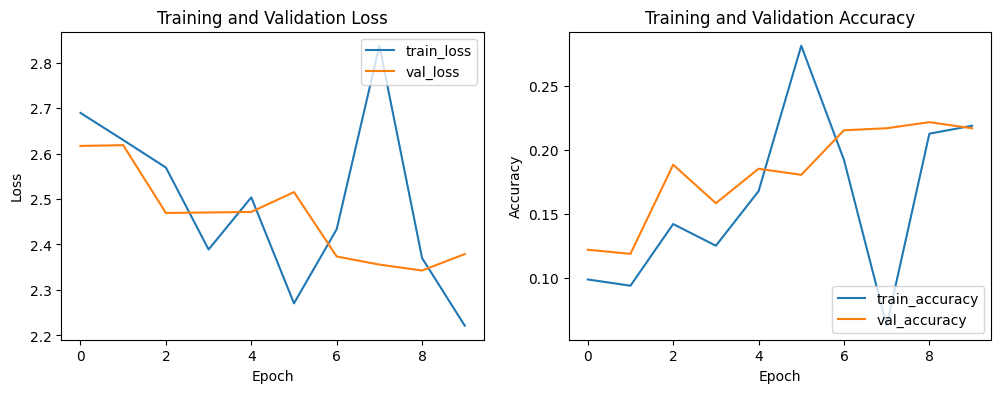

In [42]:
import matplotlib.pyplot as plt

# Plot the training loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(H.history["loss"], label="train_loss")
plt.plot(H.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")

plt.subplot(1, 2, 2)
plt.plot(H.history["accuracy"], label="train_accuracy")
plt.plot(H.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 362ms/step
                                      precision    recall  f1-score   support

Africanized Honey Bees (Killer Bees)       0.90      0.90      0.90        41
                              Aphids       0.73      0.57      0.64        42
                           Armyworms       0.52      0.72      0.60        43
         Brown Marmorated Stink Bugs       0.86      0.84      0.85        45
                     Cabbage Loopers       0.64      0.81      0.72        42
                       Citrus Canker       0.59      0.92      0.72        39
             Colorado Potato Beetles       0.87      0.89      0.88        46
                         Corn Borers       0.78      0.66      0.72        44
                       Corn Earworms       0.88      0.56      0.68        50
                      Fall Armyworms       0.50      0.23      0.32        39
                         Fruit Flies       0.78      0.82      0.80        39
                      

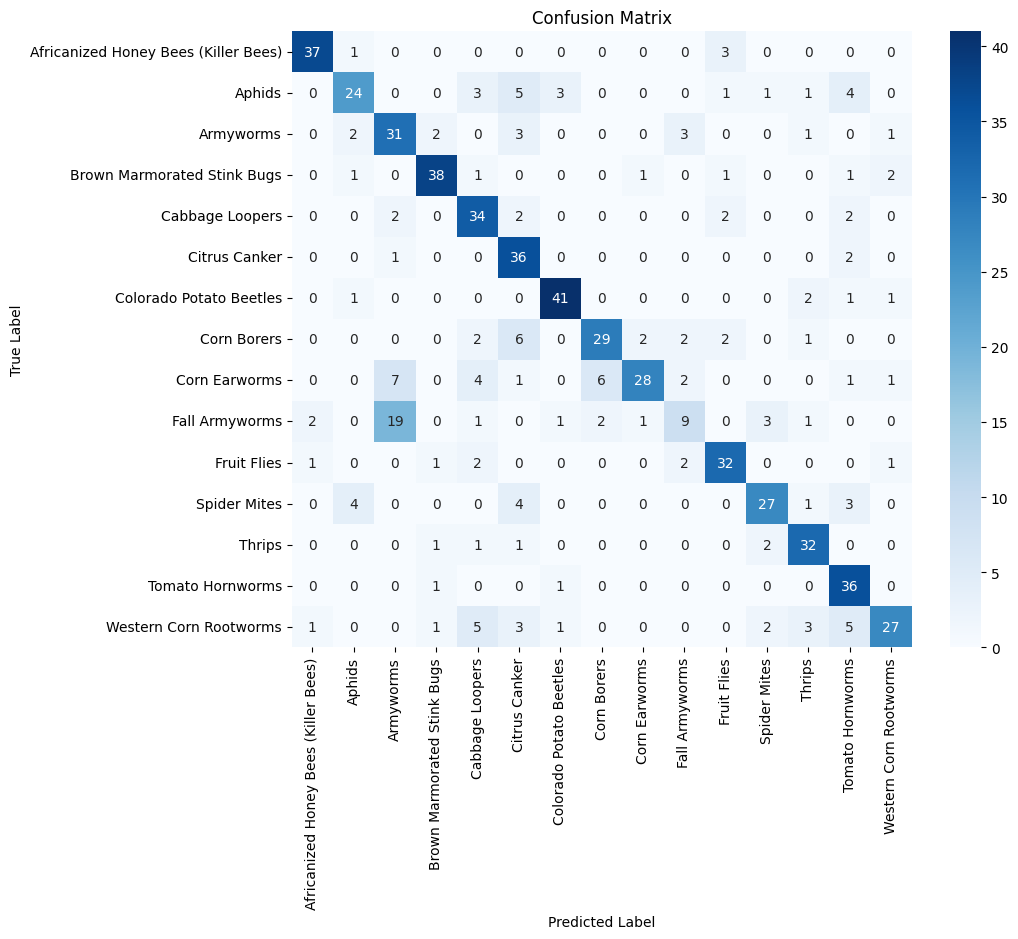

In [44]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Evaluate the model on the test set
predictions = model.predict(testX, batch_size=BS)
predictions = np.argmax(predictions, axis=1)
testY_labels = np.argmax(testY, axis=1)

# Print classification report
print(classification_report(testY_labels, predictions, target_names=lb.classes_))

# Plot confusion matrix
conf_matrix = confusion_matrix(testY_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=lb.classes_, yticklabels=lb.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

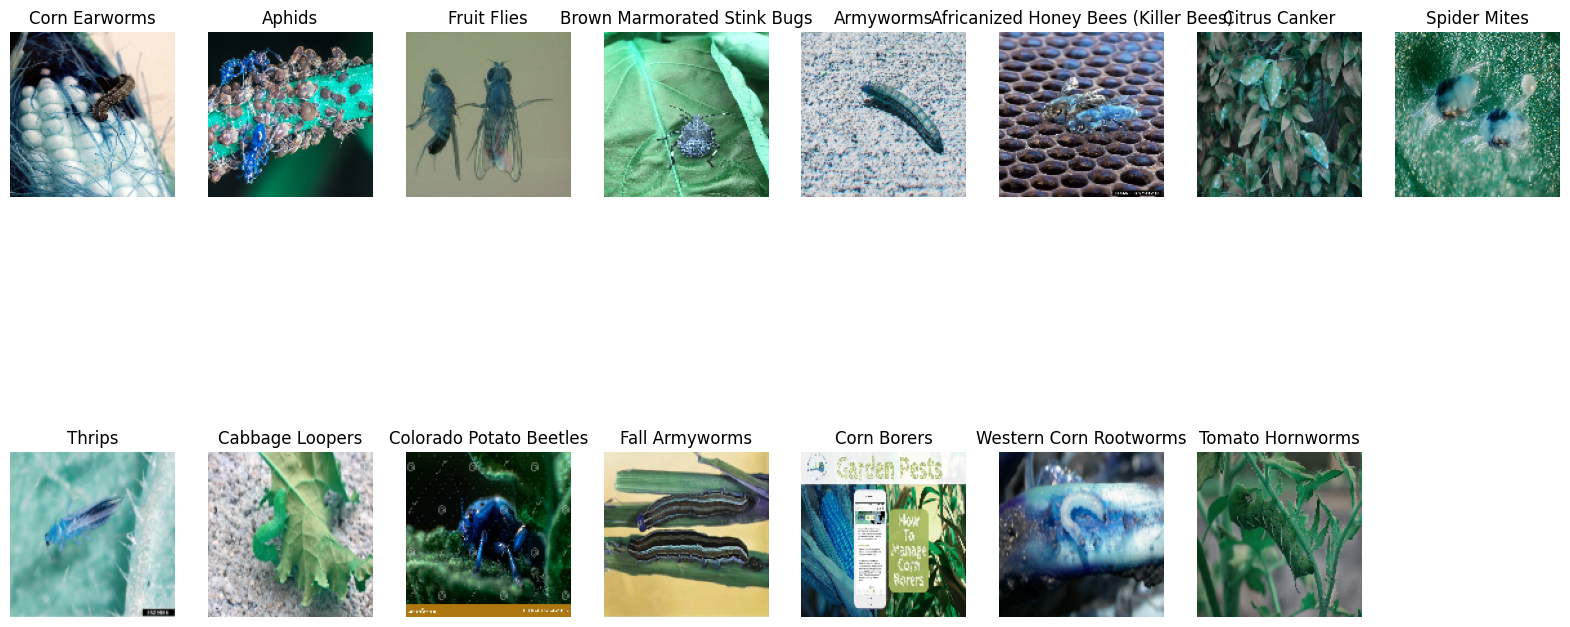

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Convert labels to numpy array if not already
if not isinstance(labels, np.ndarray):
    labels = np.array(labels)

# Convert each label from one-hot encoded to its corresponding class label index
labels_indices = np.argmax(labels, axis=1)

# Dictionary to store one image per class
class_images = {}

# Iterate over the dataset
for image, label_index in zip(data, labels_indices):
    # Decode the label index to get the class name
    label_name = lb.classes_[label_index]

    # If this label has not been added to the dictionary, add it
    if label_name not in class_images:
        class_images[label_name] = image

    # If we have collected one image per class, break out of the loop
    if len(class_images) == len(lb.classes_):
        break

# Plot the images
plt.figure(figsize=(20, 10))
for i, (label, image) in enumerate(class_images.items()):
    plt.subplot(2, (len(lb.classes_) + 1) // 2, i + 1)
    plt.imshow(image)
    plt.title(label)
    plt.axis('off')

plt.show()


In [49]:
from collections import Counter

def count_images_in_folders(dataset_path):
    folder_counts = Counter()
    for subdir, dirs, files in os.walk(dataset_path):
        num_images = len([f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        if num_images > 0:
            folder_counts[subdir] = num_images
    return folder_counts

image_counts = count_images_in_folders(dataset_path)
for folder, count in image_counts.items():
    print(f"Folder: {folder} - Number of images: {count}")


Folder: /content/dataset/farm_insects/Corn Earworms - Number of images: 110
Folder: /content/dataset/farm_insects/Aphids - Number of images: 87
Folder: /content/dataset/farm_insects/Fruit Flies - Number of images: 100
Folder: /content/dataset/farm_insects/Brown Marmorated Stink Bugs - Number of images: 114
Folder: /content/dataset/farm_insects/Armyworms - Number of images: 94
Folder: /content/dataset/farm_insects/Africanized Honey Bees (Killer Bees) - Number of images: 96
Folder: /content/dataset/farm_insects/Citrus Canker - Number of images: 104
Folder: /content/dataset/farm_insects/Spider Mites - Number of images: 118
Folder: /content/dataset/farm_insects/Thrips - Number of images: 109
Folder: /content/dataset/farm_insects/Cabbage Loopers - Number of images: 104
Folder: /content/dataset/farm_insects/Colorado Potato Beetles - Number of images: 112
Folder: /content/dataset/farm_insects/Fall Armyworms - Number of images: 110
Folder: /content/dataset/farm_insects/Corn Borers - Number of 

In [48]:
!pip install nbconvert
!jupyter nbconvert --to html /content/Ancy_Dissertation.ipynb

[NbConvertApp] Converting notebook /content/Ancy_Dissertation.ipynb to html
[NbConvertApp] Writing 2150679 bytes to /content/Ancy_Dissertation.html
